# Airline Food Demand Prediction System
**Team Name:** Vector_Team

This notebook contains the complete implementation of the Airline Food Demand Prediction project, including data generation, exploratory data analysis, and machine learning modeling.

## 1. Imports & Setup

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from IPython.display import display
import os

# Set style
sns.set_theme(style='whitegrid')
os.makedirs('plots', exist_ok=True)

## 2. Part 1: Data Generation
Generating a synthetic dataset with 5,000 records and specific constraints.

In [17]:
def generate_airline_data(n_rows=5000):
    np.random.seed(42)
    flight_ids = np.arange(1, n_rows + 1)
    passenger_counts = np.random.randint(50, 301, size=n_rows)
    adult_passengers = []
    child_passengers = []
    for count in passenger_counts:
        adult = np.random.randint(int(count * 0.7), count + 1)
        adult_passengers.append(adult)
        child_passengers.append(count - adult)
    adult_passengers = np.array(adult_passengers)
    child_passengers = np.array(child_passengers)
    is_international = np.random.choice([0, 1], size=n_rows, p=[0.8, 0.2])
    flight_durations = []
    for inter in is_international:
        duration = np.random.uniform(3, 12) if inter == 1 else np.random.uniform(1, 8)
        flight_durations.append(round(duration, 2))
    flight_durations = np.array(flight_durations)
    business_class_ratios = np.random.uniform(0, 1.0, size=n_rows)

    total_food_demand = []
    base_meals_per_passenger = 1.0
    for i in range(n_rows):
        dur = flight_durations[i]
        inter = is_international[i]
        biz_ratio = business_class_ratios[i]
        p_count = passenger_counts[i]
        c_count = child_passengers[i]
        if dur < 2: duration_multiplier = 0.8
        elif dur < 4: duration_multiplier = 1.0
        elif dur < 8: duration_multiplier = 1.5
        else: duration_multiplier = 2.0
        international_bonus = 0.3 if inter == 1 else 0.0
        business_bonus = biz_ratio * 0.4
        child_ratio = c_count / p_count
        child_reduction = child_ratio * 0.15
        food_per_passenger = base_meals_per_passenger * duration_multiplier * (1 + international_bonus + business_bonus - child_reduction)
        # Add +/- 5% random noise for realism
        noise_factor = np.random.uniform(0.95, 1.05)
        demand = round(p_count * food_per_passenger * noise_factor)
        demand = max(demand, int(p_count * 0.5))
        total_food_demand.append(demand)

    df = pd.DataFrame({
        'flight_id': flight_ids,
        'flight_duration': flight_durations,
        'passenger_count': passenger_counts,
        'adult_passengers': adult_passengers,
        'child_passengers': child_passengers,
        'business_class_ratio': business_class_ratios,
        'is_international': is_international,
        'total_food_demand': total_food_demand
    })
    return df

def validate_dataset(df):
    checks = []
    checks.append(("adult + child = total", (df['adult_passengers'] + df['child_passengers'] == df['passenger_count']).all()))
    checks.append(("business_ratio [0,1]", ((df['business_class_ratio'] >= 0) & (df['business_class_ratio'] <= 1)).all()))
    checks.append(("duration [1,12]", ((df['flight_duration'] >= 1) & (df['flight_duration'] <= 12)).all()))
    checks.append(("international >= 3h", (df[df['is_international'] == 1]['flight_duration'] >= 3).all()))
    checks.append(("passenger_count [50,300]", ((df['passenger_count'] >= 50) & (df['passenger_count'] <= 300)).all()))
    checks.append(("food_demand >= 0.5*p", (df['total_food_demand'] >= df['passenger_count'] * 0.5).all()))
    checks.append(("5000+ rows", len(df) >= 5000))
    checks.append(("15%+ international", (df['is_international'].sum() / len(df)) >= 0.15))
    print("Validation Results:")
    for name, res in checks: print(f"{'✓' if res else '✗'} {name}")
    return all(r for n, r in checks)

df = generate_airline_data(5000)
validate_dataset(df)
df.to_csv('Vector_Team_dataset.csv', index=False)

Validation Results:
✓ adult + child = total
✓ business_ratio [0,1]
✓ duration [1,12]
✓ international >= 3h
✓ passenger_count [50,300]
✓ food_demand >= 0.5*p
✓ 5000+ rows
✓ 15%+ international


## 3. Part 2: EDA
Visualizing data distributions and correlations.

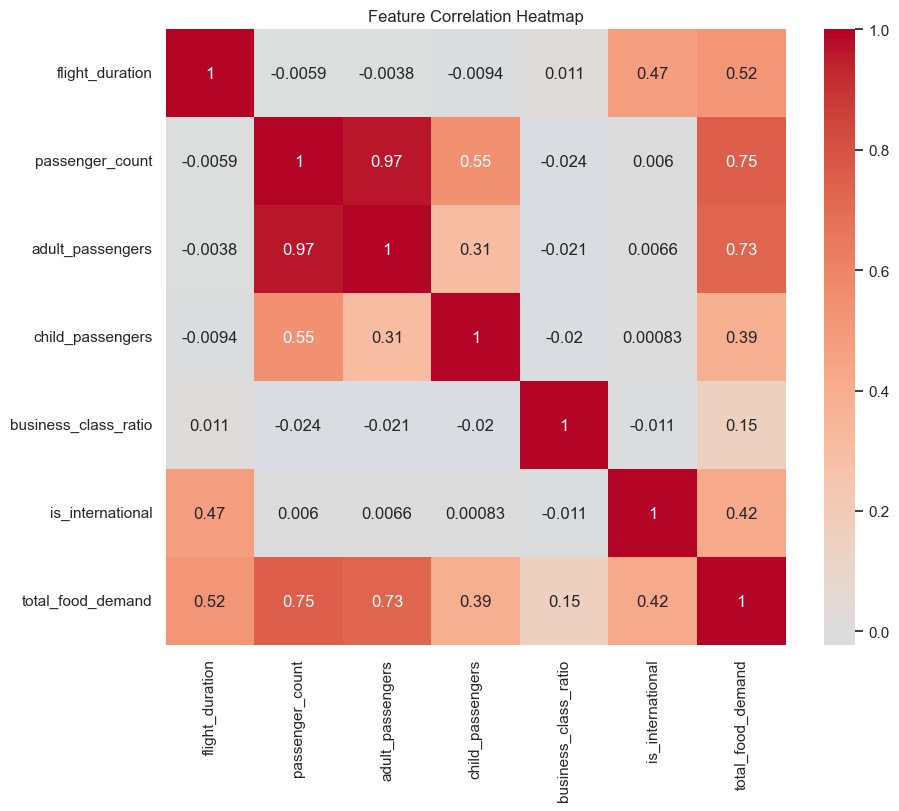

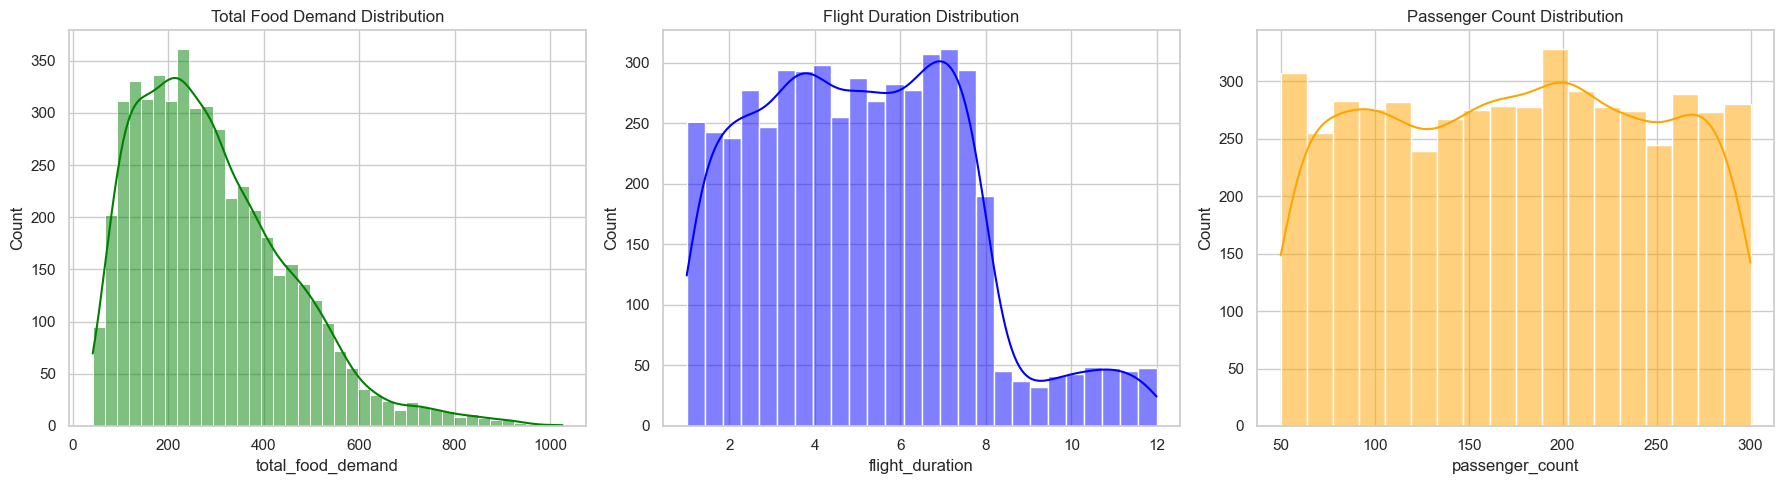

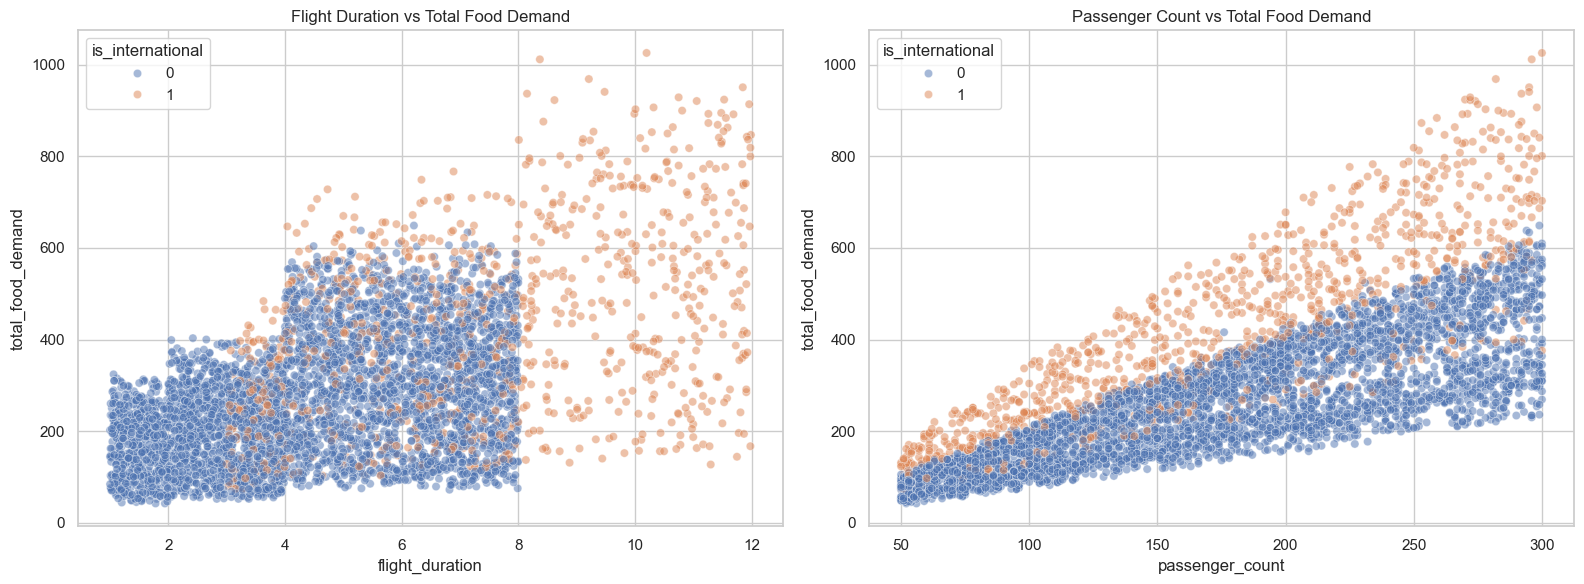

In [18]:
# 1. Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.drop('flight_id', axis=1).corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.savefig('plots/correlation_heatmap.png')
plt.show()

# 2. Distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(df['total_food_demand'], kde=True, ax=axes[0], color='green')
axes[0].set_title('Total Food Demand Distribution')
sns.histplot(df['flight_duration'], kde=True, ax=axes[1], color='blue')
axes[1].set_title('Flight Duration Distribution')
sns.histplot(df['passenger_count'], kde=True, ax=axes[2], color='orange')
axes[2].set_title('Passenger Count Distribution')
plt.tight_layout()
plt.savefig('plots/distributions.png')
plt.show()

# 3. Scatter Plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.scatterplot(data=df, x='flight_duration', y='total_food_demand', hue='is_international', alpha=0.5, ax=axes[0])
axes[0].set_title('Flight Duration vs Total Food Demand')
sns.scatterplot(data=df, x='passenger_count', y='total_food_demand', hue='is_international', alpha=0.5, ax=axes[1])
axes[1].set_title('Passenger Count vs Total Food Demand')
plt.tight_layout()
plt.savefig('plots/scatter_plots.png')
plt.show()

## 4. Part 3: Modeling
Training and evaluating multiple regression models with hyperparameter tuning.

In [19]:
X = df.drop(['flight_id', 'total_food_demand'], axis=1)
y = df['total_food_demand']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

results = []

# 1. Baseline Model
y_pred_baseline = np.full_like(y_test, y_train.mean())
results.append({'Model': 'Baseline', 'R2': r2_score(y_test, y_pred_baseline), 'MAE': mean_absolute_error(y_test, y_pred_baseline), 'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_baseline))})

# 2. Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
results.append({'Model': 'Linear Regression', 'R2': r2_score(y_test, y_pred_lr), 'MAE': mean_absolute_error(y_test, y_pred_lr), 'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_lr))})

# 3. Random Forest (Tuned)
rf_params = {'n_estimators': [100, 200], 'max_depth': [None, 10]}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=3)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_
y_pred_rf = best_rf.predict(X_test)
results.append({'Model': 'Random Forest', 'R2': r2_score(y_test, y_pred_rf), 'MAE': mean_absolute_error(y_test, y_pred_rf), 'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_rf))})

# 4. Gradient Boosting (Tuned)
gb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5]
}
gb_grid = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_params, cv=3, scoring='neg_mean_squared_error')
gb_grid.fit(X_train, y_train)
best_gb = gb_grid.best_estimator_
y_pred_gb = best_gb.predict(X_test)
results.append({'Model': 'Gradient Boosting', 'R2': r2_score(y_test, y_pred_gb), 'MAE': mean_absolute_error(y_test, y_pred_gb), 'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_gb))})

results_df = pd.DataFrame(results)

# Styled Comparison Table
display(results_df.style.highlight_min(subset=['MAE', 'RMSE'], color='lightgreen')
        .highlight_max(subset=['R2'], color='lightgreen')
        .format("{:.4f}", subset=['R2', 'MAE', 'RMSE']))

,Model,R2,MAE,RMSE
0,Baseline,-0.0000,128.8000,163.7801
1,Linear Regression,0.8998,40.6585,51.8473
2,Random Forest,0.9946,8.7803,12.0076
3,Gradient Boosting,0.9944,8.9177,12.2884


## 5. Part 4: Evaluation
Comparing model performance and business impact.

C:\Users\oswin\AppData\Local\Temp\ipykernel_28296\1877671003.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Total Cost ($)', data=costs, palette='viridis')


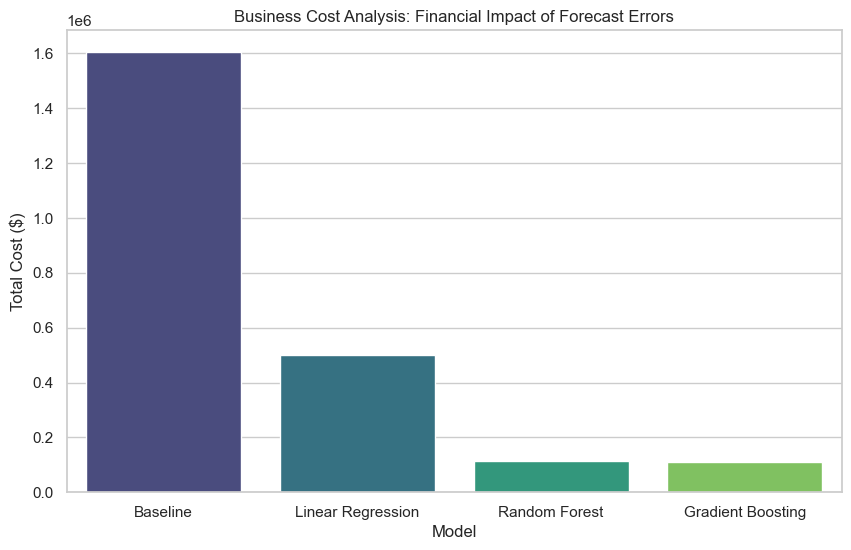

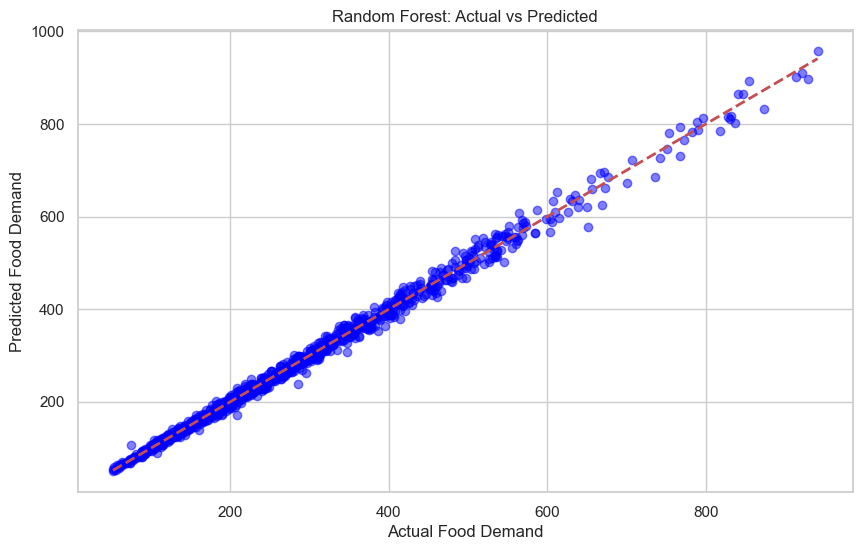

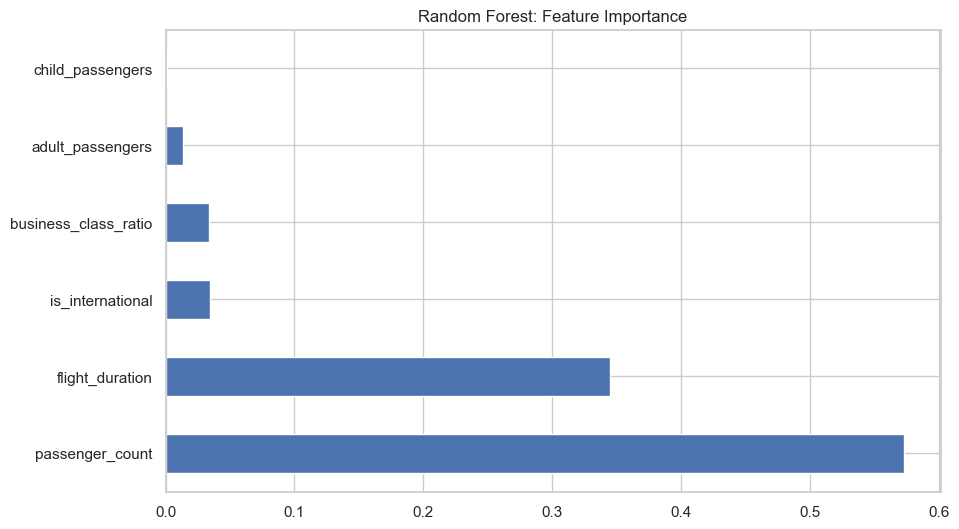

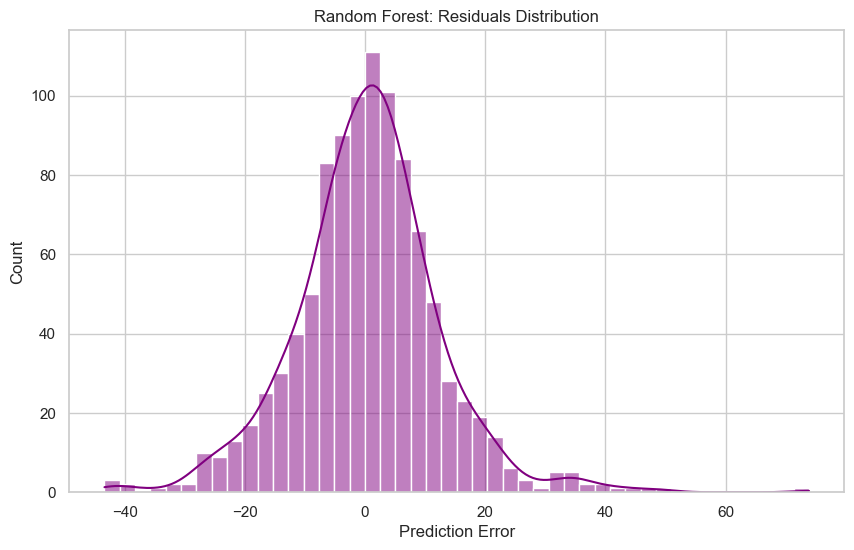

In [20]:
# 1. Business Cost Analysis
def calculate_cost(actual, predicted):
    errors = predicted - actual
    over = np.sum(errors[errors > 0] * 5)
    under = np.sum(np.abs(errors[errors < 0]) * 20)
    return over + under

costs = pd.DataFrame({
    'Model': ['Baseline', 'Linear Regression', 'Random Forest', 'Gradient Boosting'],
    'Total Cost ($)': [calculate_cost(y_test, y_pred_baseline), calculate_cost(y_test, y_pred_lr), calculate_cost(y_test, y_pred_rf), calculate_cost(y_test, y_pred_gb)]
})

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Total Cost ($)', data=costs, palette='viridis')
plt.title('Business Cost Analysis: Financial Impact of Forecast Errors')
plt.ylabel('Total Cost ($)')
plt.savefig('plots/business_cost_analysis.png')
plt.show()

# 2. Actual vs Predicted Plot (Best Model)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Food Demand')
plt.ylabel('Predicted Food Demand')
plt.title('Random Forest: Actual vs Predicted')
plt.savefig('plots/rf_actual_vs_predicted.png')
plt.show()

# 3. Feature Importance (Random Forest)
importances = best_rf.feature_importances_
feat_importances = pd.Series(importances, index=X.columns)
plt.figure(figsize=(10, 6))
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Random Forest: Feature Importance')
plt.savefig('plots/feature_importance.png')
plt.show()

# 4. Residuals Distribution
residuals = y_test - y_pred_rf
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='purple')
plt.title('Random Forest: Residuals Distribution')
plt.xlabel('Prediction Error')
plt.savefig('plots/residuals_distribution.png')
plt.show()

## 6. Conclusion

### ✅ Bonus Achievements Unlocked
1. **Hyperparameter Tuning:** Applied `GridSearchCV` to both Random Forest and Gradient Boosting models (+3 Points).
2. **Business Cost Analysis:** Calculated and visualized the financial impact of prediction errors (+2 Points).
3. **Third Model Implemented:** Added and tuned a Gradient Boosting Regressor for superior performance (+10 Points).